In [1]:
import lsst.daf.butler as daf_butler
import numpy as np
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
from lsst.geom import SpherePoint,Angle
import astropy.units as u
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import pandas as pd
Gaia.ROW_LIMIT = -1
afwDisplay.setDefaultBackend("firefly")

def coordToPix(wcs,ra,dec):
    spherePt = SpherePoint(Angle(ra*np.pi/180),Angle(dec*np.pi/180))
    return wcs.skyToPixel(spherePt)

In [362]:
collections=["u/elhoward/TOO/0725J",
             "u/elhoward/TOO/0725J/MMADS_candidates",
             "LSSTCam/runs/nightlyValidation/20250728/w_2025_30/DM-50157",
             "u/elhoward/TOO/0725J/DESGW_candidates_v2",
             "u/elhoward/TOO/0725J/test",
             "u/elhoward/TOO/0725J/test/doSubtractBackground",
             "u/elhoward/TOO/0725J/test/allowKernelSourceDetection"
            ]

# collections=["u/elhoward/TOO/0725J/AT2025sib",
#              "LSSTCam/runs/nightlyValidation/20250728/w_2025_30/DM-50157"
#             ]

# bobCollections = ["LSSTCam/runs/nightlyValidation/20250728/w_2025_30/DM-50157","u/rea3/test_0725J_v10_mask_v6"]

collections = ["u/rea3/too_0725J",
               "LSSTCam/runs/nightlyValidation/20250728/w_2025_30/DM-50157",]
repo="embargo_new"

In [363]:
MyBut = daf_butler.Butler(repo,collections=collections)
# BobsBut = daf_butler.Butler(repo,collections=bobCollections)

In [364]:
finalVisits = []
for k in np.arange(2025072800099,2025072800159):
    if int(str(k)[-1])!=9:
        finalVisits.append(k)

In [365]:
detector = 25
visit = 2025072800105

In [366]:
RefButler = daf_butler.Butler("embargo", collections="refcats")

In [367]:
# simpleCat = RefButler.get("the_monster_20250219", dataId={"htm7":203118})

In [368]:
# simpleCat[0]

In [369]:
diffRefs = list(MyBut.query_datasets("difference_image",where=f"exposure={visit} and instrument='LSSTCam' and detector={detector}"))
tempRefs = list(MyBut.query_datasets("template_matched",where=f"exposure={visit} and instrument='LSSTCam' and detector={detector}"))
searchRefs = list(MyBut.query_datasets("preliminary_visit_image",where=f"exposure={visit} and instrument='LSSTCam' and detector={detector}"))
diaSourceRefs = list(MyBut.query_datasets("dia_source_unfiltered",where=f"exposure={visit} and instrument='LSSTCam' and detector={detector}"))
# searchRefs = list(BobsBut.query_datasets("difference_image",where=f"exposure={visit} and instrument='LSSTCam' and detector={detector}"))

In [370]:
diff = MyBut.get(diffRefs[0])
temp = MyBut.get(tempRefs[0])
search = MyBut.get(searchRefs[0])
diaSource = MyBut.get(diaSourceRefs[0])

In [371]:
tab = diaSource.asAstropy()

In [372]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" 

In [373]:
center_ra = 234.755524
center_dec = -36.425993
rad = u.Quantity(.3, u.deg)
cols = ['ra', 'dec', 'pmra',"pmdec"]

In [374]:
coord = SkyCoord(ra=center_ra, dec=center_dec, unit=(u.degree, u.degree), frame='icrs')
r = Gaia.query_object_async(coordinate=coord, height=rad,width=rad, columns=cols)

INFO: Query finished. [astroquery.utils.tap.core]


In [375]:
gaia_table = r.to_pandas()

relRows = []

for __, row in gaia_table.iterrows():
    if not np.isnan(row[["ra","dec","pmra","pmdec"]].values).any():
        relRows.append(row[["ra","dec","pmra","pmdec"]])

In [379]:
display = afwDisplay.Display(frame=0,dpi=200)
display.scale('linear', 'zscale')
display.image(search)

scale=0.001
thisWCS = search.getWcs()
with display.Buffering():
    for myx,myy in zip(tab["base_SdssCentroid_x"],tab["base_SdssCentroid_y"]):
        display.dot("o",myx,myy,ctype='blue',size=20)
    # for record in relRows[::2]:
    #     start = coordToPix(thisWCS,record["ra"],record["dec"])
    #     display.dot("o",start[0],start[1],size=10,ctype="orange")
    #     end = coordToPix(thisWCS,record["ra"]+scale*record["pmra"],record["dec"]+scale*record["pmdec"])
    #     end1 = coordToPix(thisWCS,record["ra"]+0.1*scale*record["pmra"],record["dec"]+0.1*scale*record["pmdec"])
    #     display.line([start,end], ctype='orange')
    coordPix = coordToPix(thisWCS,center_ra,center_dec)
    display.dot("o",coordPix[0],coordPix[1],size=20,ctype="red")

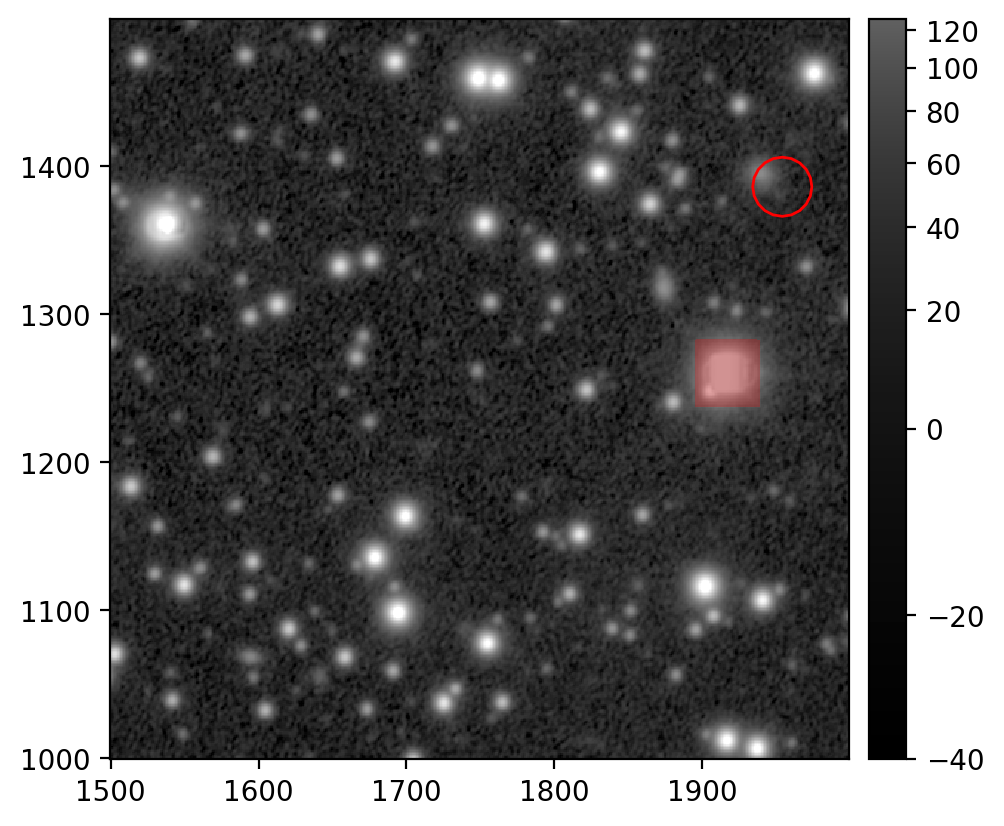

In [346]:
display = afwDisplay.Display(frame=1,dpi=200)
display.scale('asinh', 'zscale')
display.image(temp)

scale=0.001
thisWCS = temp.getWcs()
with display.Buffering():
    # for record in relRows[::2]:
    #     start = coordToPix(thisWCS,record["ra"],record["dec"])
    #     display.dot("o",start[0],start[1],size=10,ctype="orange")
    #     end = coordToPix(thisWCS,record["ra"]+scale*record["pmra"],record["dec"]+scale*record["pmdec"])
    #     end1 = coordToPix(thisWCS,record["ra"]+0.1*scale*record["pmra"],record["dec"]+0.1*scale*record["pmdec"])
    #     display.line([start,end], ctype='orange')
    coordPix = coordToPix(thisWCS,center_ra,center_dec)
    display.dot("o",coordPix[0],coordPix[1],size=20,ctype="red")

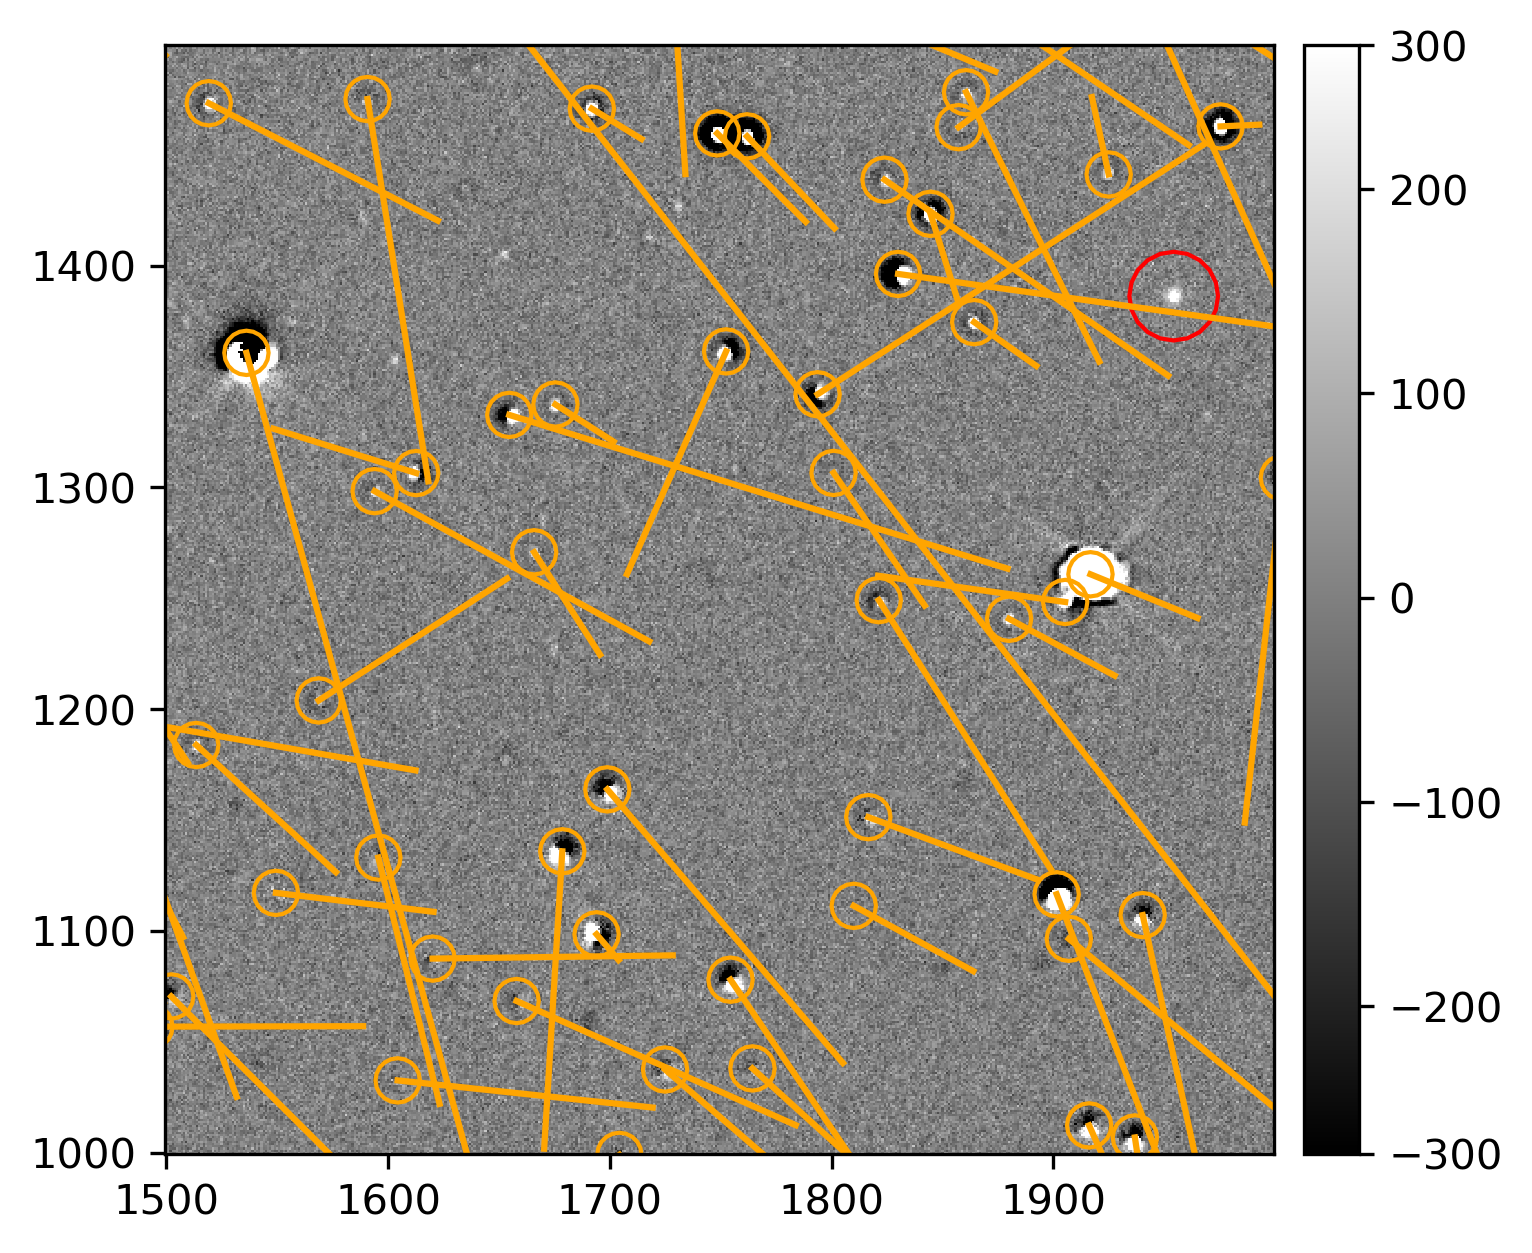

In [345]:
display = afwDisplay.Display(frame=2,dpi=300)
display.setMaskTransparency(100)
display.scale('linear', 'zscale')
display.image(diff)

scale=0.001
thisWCS = diff.getWcs()
with display.Buffering():
    for record in relRows:
        start = coordToPix(thisWCS,record["ra"],record["dec"])
        display.dot("o",start[0],start[1],size=10,ctype="orange")
        end = coordToPix(thisWCS,record["ra"]+scale*record["pmra"],record["dec"]+scale*record["pmdec"])
        end1 = coordToPix(thisWCS,record["ra"]+0.1*scale*record["pmra"],record["dec"]+0.1*scale*record["pmdec"])
        display.line([start,end], ctype='orange')
    coordPix = coordToPix(thisWCS,center_ra,center_dec)
    display.dot("o",coordPix[0],coordPix[1],size=20,ctype="red")

In [360]:
header="""# %ECSV 1.0
# ---
# datatype:
# - {name: instrument, datatype: string}
# - {name: exposure, datatype: int64}
# - {name: detector, datatype: int64}
# schema: astropy-2.0
instrument exposure detector"""

In [351]:
b = [[2025072800105,25],
[2025072800104,170],
[2025072800105,21],
[2025072800104,167],
[2025072800104,185],
[2025072800100,131],
[2025072800105,97],
[2025072800105,56]]



In [359]:
print(header)
for a in b:
    vis = a[0]
    det = a[1]
    for plus in np.arange(6):
        
        print("LSSTCam {} {}".format(vis+plus*10,det))

# %ECSV 1.0
# ---
# datatype:
# - {name: instrument, datatype: string}
# - {name: exposure, datatype: int64}
# - {name: detector, datatype: int64}
# schema: astropy-2.0
instrument exposure detector
LSSTCam 2025072800105 25
LSSTCam 2025072800115 25
LSSTCam 2025072800125 25
LSSTCam 2025072800135 25
LSSTCam 2025072800145 25
LSSTCam 2025072800155 25
LSSTCam 2025072800104 170
LSSTCam 2025072800114 170
LSSTCam 2025072800124 170
LSSTCam 2025072800134 170
LSSTCam 2025072800144 170
LSSTCam 2025072800154 170
LSSTCam 2025072800105 21
LSSTCam 2025072800115 21
LSSTCam 2025072800125 21
LSSTCam 2025072800135 21
LSSTCam 2025072800145 21
LSSTCam 2025072800155 21
LSSTCam 2025072800104 167
LSSTCam 2025072800114 167
LSSTCam 2025072800124 167
LSSTCam 2025072800134 167
LSSTCam 2025072800144 167
LSSTCam 2025072800154 167
LSSTCam 2025072800104 185
LSSTCam 2025072800114 185
LSSTCam 2025072800124 185
LSSTCam 2025072800134 185
LSSTCam 2025072800144 185
LSSTCam 2025072800154 185
LSSTCam 2025072800100 131
LSSTCam 

array([0, 1, 2, 3, 4, 5])